**Notebook used to make particle-level evaluation plots**

- Stacked histograms
- Particle $p_T$, $\eta$, $\phi$
- Efficiency and Fake rate

In [1]:
import os, sys, glob
import pickle as pkl
import uproot
import awkward as ak
import vector
import numpy as np
vector.register_awkward()

import boost_histogram as bh
import numba
import mplhep
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import tqdm

mplhep.set_style(mplhep.styles.CMS)

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_7285/689795866.py:19: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [2]:
sys.path += ["../../mlpf/plotting//"]
from plot_utils import EVALUATION_DATASET_NAMES, experiment_label
from plot_utils import SAMPLE_LABEL_CMS, pid_to_text, EXPERIMENT_LABELS

In [3]:
def sample_label(ax, sample, additional_text="", x=0.03, y=0.97, fontsize=20):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, fontsize=fontsize)

def cms_label(ax):
    return experiment_label(ax, experiment="CMS", tag1="Simulation Preliminary", tag2="Run 3 (13.6 TeV)", x1=0.13)

In [4]:
@numba.njit
def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_particles(eta1, eta2, phi1, phi2, deltaR_cut):
    nev = len(eta1)
    ptcl_inds_1_ev = []
    ptcl_inds_2_ev = []
    best_drs_ev = []
    for iev in range(nev):
        ptcl_inds_1 = []
        ptcl_inds_2 = []
        best_drs = []

        # loop over the first collection
        pfs_used = np.zeros(len(eta2[iev]))
        for ip1 in range(len(eta1[iev])):
            # compute deltaR from this particle to all particles in the other collection
            drs = 999*np.ones(len(eta2[iev]), dtype=np.float64)

            # loop over the second collection
            for ip2 in range(len(eta2[iev])):
                if pfs_used[ip2]==1:
                    continue
                _eta1 = eta1[iev][ip1]
                _eta2 = eta2[iev][ip2]
                _phi1 = phi1[iev][ip1]
                _phi2 = phi2[iev][ip2]

                dr = deltar(_eta1, _phi1, _eta2, _phi2)
                drs[ip2] = dr

            if len(drs) > 0:
                # find closest match to this particle
                min_idx_dr = np.argmin(drs)

                # has to be closer than the deltaR_cut
                if drs[min_idx_dr] < deltaR_cut:
                    ptcl_inds_1.append(ip1)
                    ptcl_inds_2.append(min_idx_dr)
                    best_drs.append(drs[min_idx_dr])
                    pfs_used[min_idx_dr] = 1
                
        ptcl_inds_1_ev.append(ptcl_inds_1)
        ptcl_inds_2_ev.append(ptcl_inds_2)
        best_drs_ev.append(best_drs)
    return ptcl_inds_1_ev, ptcl_inds_2_ev, best_drs_ev

def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values
    
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1

def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

In [5]:
dataset = "cms"

save_as = {
    "cms_pf_qcd_nopu": "QCD_noPU_13p6",
    "cms_pf_ttbar_nopu": "TTbar_noPU_13p6",
}

In [6]:
dataset = "cms"

save_as = {
    "cms_pf_qcd_nopu": "QCD_noPU_13p6",
    "cms_pf_ttbar_nopu": "TTbar_noPU_13p6",
}

sample = "cms_pf_ttbar_nopu"
# sample = "cms_pf_qcd_nopu"

In [7]:
# PDG IDs of neutrinos
vELE_PDGID = 12
vMU_PDGID  = 14
vTAU_PDGID = 16

def fix_ak(arr):
    # replace None with empty list
    return ak.Array([x if x is not None else [] for x in arr])

def process_file(fn):
    # Load events
    with open(fn, "rb") as f:
        events = ak.Array(pkl.load(f))
    gen = events["packedGenParticles"]
    pf  = events["packedPFCandidates"]

    # Compute masks
    status = gen["status"]
    pdgId  = gen["pdgId"]
    mask_final = (status == 1)
    mask_nu    = (abs(pdgId) == vELE_PDGID) | \
                 (abs(pdgId) == vMU_PDGID)  | \
                 (abs(pdgId) == vTAU_PDGID)
    mask = mask_final & ~mask_nu

    # Slice and zip
    sliced = {
        "GenCands_pt":    gen.pt[mask],
        "GenCands_eta":   gen.eta[mask],
        "GenCands_phi":   gen.phi[mask],
        "GenCands_pdgId": gen.pdgId[mask],
        "PFCands_pt":     pf.pt,
        "PFCands_eta":    pf.eta,
        "PFCands_phi":    pf.phi,
        "PFCands_pdgId":  pf.pdgId,
    }
    return ak.zip(sliced, depth_limit=1)

from concurrent.futures import ThreadPoolExecutor
def load_multiprocess(files, max_workers=None):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm.tqdm(executor.map(process_file, files), total=len(files)))
    successful_results = [r for r in results if r is not None]

    return ak.concatenate(successful_results)

def load_singleprocess(files):
    results = []
    for fn in tqdm.tqdm(files):
        try:
            ret = process_file(fn)
            results.append(ret)
        except Exception as e:
            print("could not process " + fn)
    return ak.concatenate(results)

In [9]:
path_mlpf = f"../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/{save_as[sample]}_mlpfpu/step3_MINI_*.pkl"
path_pf = f"../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/{save_as[sample]}_pf/step3_MINI_*.pkl"

# mlpf
files = glob.glob(path_mlpf)
# files = files[:1000]
# data_mlpf =  load_multiprocess([fn for fn in files], 16)
data_mlpf =  load_singleprocess([fn for fn in files])

# pf
files = glob.glob(path_pf)
# files = files[:1000]
# data_pf =  load_multiprocess([fn for fn in files], 16)
data_pf =  load_singleprocess([fn for fn in files])

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2050/2050 [02:22<00:00, 14.40it/s]


In [10]:
import particle
from particle import Particle
from particle import PDGID # https://github.com/scikit-hep/particle

import numba
from numba import njit
from numba.typed import Dict
from numba.core import types

@numba.njit
def get_charge_numba(pids, pid_to_charge_numbadict):
    ret = np.zeros(len(pids))
    for i in range(len(pids)):
        ret[i] = pid_to_charge_numbadict[pids[i]]
    return ret
    
def get_charge_array(pdgids):
    pids_uniq = np.unique(pdgids)
    pid_to_charge = {
        pid: Particle.from_pdgid(pid).charge for pid in pids_uniq
    }
    
    pid_to_charge_numbadict = Dict.empty(key_type=types.int64, value_type=types.float64)
    for pid, c in pid_to_charge.items():
        pid_to_charge_numbadict[pid] = c

    ret = get_charge_numba(pdgids, pid_to_charge_numbadict)
    return ak.Array(ret)

def remap_pid_gen(data):
    """
    GenCands have all sorts of PID so must remap
    """
    pid = np.abs(np.asarray(ak.flatten(data["GenCands_pdgId"])))
    
    pa = ak.flatten(np.abs(data["GenCands_pdgId"]))
    pc = np.abs(get_charge_array(ak.flatten(data["GenCands_pdgId"])))

    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenCands_pid"] = ak.unflatten(pid, ak.count(data["GenCands_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

remap_pid_gen(data_pf)
remap_pid_gen(data_mlpf)

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


# Plot configs

In [11]:
color_code = {
    "Gen": "tab:blue",
    "PF": "tab:orange",
    "MLPF": "tab:red",
}



bins_phi = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,41),
        13: np.linspace(-3,3,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,21),
        13: np.linspace(-3,3,21),
    },  
}

marker_style = {
    'PF': 'x',
    'MLPF': 'o',
}
linestyle = {
    'Gen': '--',
    'PF': ':',
    'MLPF': '-',
}

col_pid = {
    211: "tab:blue",
    130: "tab:orange",
    22: "tab:red",
    11: "tab:green",
    13: "tab:pink",    
}

In [12]:
os.makedirs(f"./plots/{save_as[sample]}/forward_region", exist_ok=True)

# Kinematic distributions

## pT

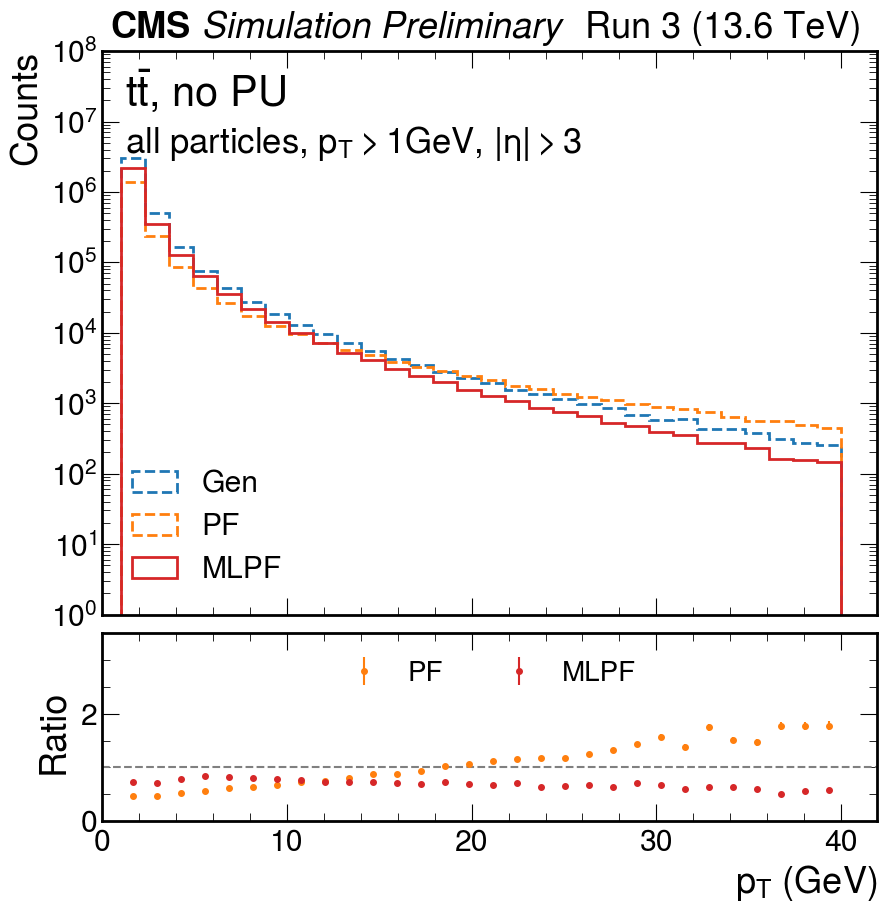

In [13]:
bins_pt = np.linspace(1,40,31)

ylim_dict = 10**8
rax_ylim_dict = (0,3.5)

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# Extract flattened arrays
sel = (abs(data_pf["GenCands_eta"]) > 3) & (abs(data_pf["GenCands_pt"]) > 1)
X_gen = ak.to_numpy(ak.flatten(abs(data_pf["GenCands_pt"][sel])))

sel = (abs(data_pf["PFCands_eta"]) > 3) & (abs(data_pf["PFCands_pt"]) > 1)
X_pf = ak.to_numpy(ak.flatten(abs(data_pf["PFCands_pt"][sel])))

sel = (abs(data_mlpf["PFCands_eta"]) > 3)& (abs(data_mlpf["PFCands_pt"]) > 1)
X_mlpf = ak.to_numpy(ak.flatten(abs(data_mlpf["PFCands_pt"][sel])))

bins = bins_pt
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_widths = 0.5 * (bins[1:] - bins[:-1])

# Histograms
h_gen, _ = np.histogram(X_gen, bins=bins)
h_pf, _ = np.histogram(X_pf, bins=bins)
h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

# Main plot
ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_ylim(1, ylim_dict)
ax.set_xlim(0)
ax.legend(loc="lower left")
cms_label(ax)

sample_label(ax, sample, fontsize=30)

plt.text(0.03, 0.82, "all particles" + ", $p_T>1$GeV, $|\eta| > 3$", transform=ax.transAxes, fontsize=25)

# Ratio + error bars
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylim(rax_ylim_dict)
rax.set_ylabel("Ratio")

rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

rax.set_xlabel("$p_T$ (GeV)")
rax.legend(fontsize=20, ncol=2, loc="upper center")

plt.savefig(f"./plots/{save_as[sample]}/forward_region/{sample}_pt_all.pdf")

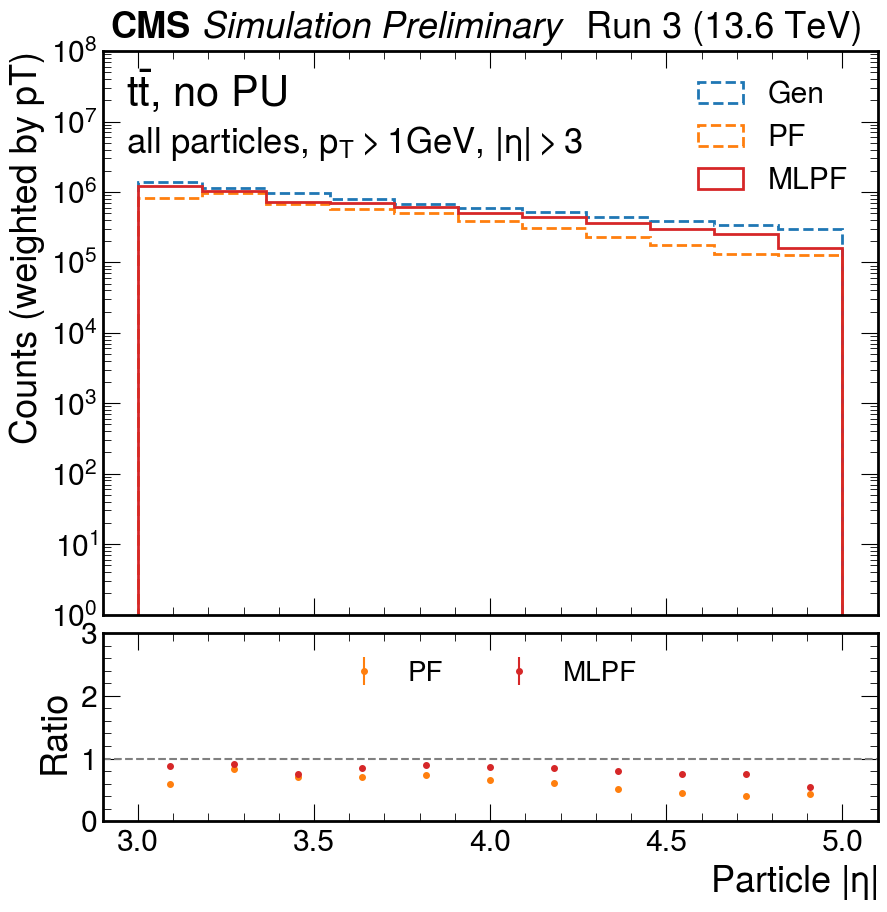

In [15]:
bins_eta = np.linspace(3,5,12)

ylim_dict = 10**8
rax_ylim_dict = (0,3)

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# Extract flattened arrays
sel = (abs(data_pf["GenCands_eta"]) > 3)  & (abs(data_pf["GenCands_pt"]) > 1)
X_gen = ak.to_numpy(ak.flatten(abs(data_pf["GenCands_eta"][sel])))
w_gen =  ak.to_numpy(ak.flatten(abs(data_pf["GenCands_pt"][sel])))

sel = (abs(data_pf["PFCands_eta"]) > 3)  & (abs(data_pf["PFCands_pt"]) > 1)
X_pf = ak.to_numpy(ak.flatten(abs(data_pf["PFCands_eta"][sel])))
w_pf = ak.to_numpy(ak.flatten(abs(data_pf["PFCands_pt"][sel])))    

sel = (abs(data_mlpf["PFCands_eta"]) > 3)  & (abs(data_mlpf["PFCands_pt"]) > 1)
X_mlpf = ak.to_numpy(ak.flatten(abs(data_mlpf["PFCands_eta"][sel])))
w_mlpf = ak.to_numpy(ak.flatten(abs(data_mlpf["PFCands_pt"][sel])))

bins = bins_eta
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_widths = 0.5 * (bins[1:] - bins[:-1])

# Histograms
h_gen, _ = np.histogram(X_gen, bins=bins, weights=w_gen)
h_pf, _ = np.histogram(X_pf, bins=bins, weights=w_pf)
h_mlpf, _ = np.histogram(X_mlpf, bins=bins, weights=w_mlpf)

# Main plot
ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

ax.set_yscale("log")
ax.set_ylabel("Counts (weighted by pT)")
ax.set_ylim(1, ylim_dict)
ax.legend()
cms_label(ax)
if "qcd" in sample:
    sample_label(ax, sample, fontsize=24)
else:
    sample_label(ax, sample, fontsize=30)

plt.text(0.03, 0.82, "all particles" + ", $p_T>1$GeV, $|\eta| > 3$", transform=ax.transAxes, fontsize=25)        

# Ratio + error bars
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylim(rax_ylim_dict)
rax.set_ylabel("Ratio")

if sample=="cms_pf_qcd_nopu":
    if (pid==211):
        rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
    else:
        rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

if sample=="cms_pf_ttbar_nopu":
    if ( (pid==211) ):
        rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates    
    else:
        rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

rax.set_xlabel(r"Particle $|\eta|$")
rax.legend(fontsize=20, ncol=2, loc="upper center")

#     plt.xlim(-2.5, 2.5)

plt.savefig(f"./plots/{save_as[sample]}/forward_region/{sample}_eta_all.pdf")